###**All you need is a Good init**###

In [fastai 2019](https://course.fast.ai/part2) Jeremy covers implementing [All you need is a Good init](https://arxiv.org/pdf/1511.06422.pdf) over [here](https://github.com/fastai/course-v3/blob/master/nbs/dl2/07a_lsuv.ipynb)

In his lectures (as a part of Part II rules) he's building the fastai library from scratch.

Here I shall try to implement a `HookCallback` which implements the paper. 
I've also added a few modifications which are necessary in my opinion. 

I'm going to be using fastai-v2 as there are a couple of bugs in fastai-v1 which hinders implementing Hooks for the text_classifier set up. I shall mention below wherever that is true. 


I'm implementing this module for the fastai.text setup



In [38]:
! pip install git+https://github.com/fastai/fastai_dev

  Cloning https://github.com/fastai/fastai_dev to /tmp/pip-req-build-jg361sbw
  Running command git clone -q https://github.com/fastai/fastai_dev /tmp/pip-req-build-jg361sbw
  Created wheel for fastai2: filename=fastai2-2.0.1-cp36-none-any.whl size=166210 sha256=684811ff03c3ada7a5b0a8e47a0f067d527f18da85e7be8494e9c50cb5eea759
  Stored in directory: /tmp/pip-ephem-wheel-cache-c8ba6gc6/wheels/3e/b2/15/88c105fb1591b06b8445ff21b00f1e03d9176d22eb9f1de934
Successfully built fastai2


In [0]:
from fastai.text import *

In [0]:
from fastai.callbacks import Hooks

In [0]:
import os 

In [0]:
import warnings

In [0]:
warnings.filterwarnings("ignore")


In [40]:
bs=48
path = untar_data(URLs.IMDB)
path.ls()





[PosixPath('/root/.fastai/data/imdb/models'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/data_clas.pkl'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [7]:
path

PosixPath('/root/.fastai/data/imdb')

In [0]:

data_lm = (TextList.from_folder(path)
           #Inputs: all the text files in path
            .filter_by_folder(include=['train', 'test', 'unsup']) 
           #We may have other temp folders that contain text files so we only keep what's in train and test
            .split_by_rand_pct(0.1)
           #We randomly split and keep 10% (10,000 reviews) for validation
            .label_for_lm()           
           #We want to do a language model so we label accordingly
            .databunch(bs=bs))
data_lm.save('data_lm.pkl')

In [0]:
data_lm = load_data(path, 'data_lm.pkl', bs=bs)


In [0]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)


In [0]:
learn_lm.save_encoder('fine_tuned_enc')


In [0]:
learn_lm.model

In [0]:

data_clas = (TextList.from_folder(path, vocab=data_lm.vocab)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

All though in his lectures and the fastai reccomended way for trainning a text classifier is to first fine tune a language model and then use the encoder for your text classifier. Here I'm using a vanilla text_classifier. 

In [0]:

data_clas = (TextList.from_folder(path)
             #grab all the text files in path
             .split_by_folder(valid='test')
             #split by train and valid folder (that only keeps 'train' and 'test' so no need to filter)
             .label_from_folder(classes=['neg', 'pos'])
             #label them all with their folders
             .databunch(bs=bs))

data_clas.save('data_clas.pkl')

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5)


In [30]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


KeyboardInterrupt: ignored

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(1, 1e-4, moms=(0.8,0.7))


In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,pretrained=False )


In [17]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


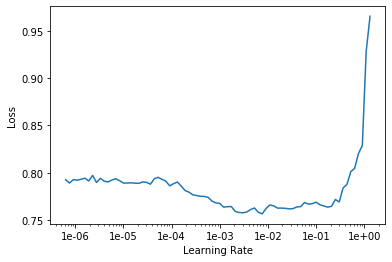

In [18]:
learn.recorder.plot()

In [19]:
learn.fit_one_cycle(1, 5e-4, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.297495,0.287845,0.882600,05:37


In [27]:
# Let's checkout why ActivationStats in it's default state does not work for LSTMs
from fastai.callbacks import ActivationStats
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,callback_fns=ActivationStats)
learn.fit_one_cycle(1, 1e-4, moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.736144,0.824923,0.500000,02:52


RuntimeError: ignored

In [0]:
from fastai.callbacks import *

#v2 
# class ActivationStats(HookCallback):
#     "Callback that record the mean and std of activations."
#     run_before=TrainEvalCallback
#     def __init__(self, with_hist=False, **kwargs):
#         super().__init__(**kwargs)
#         self.with_hist = with_hist
        
#     def begin_fit(self):
#         "Initialize stats."
#         super().begin_fit()
#         self.stats = L()
        
#     def hook(self, m, i, o): 
#         o = o.float()
#         res = {'mean': o.mean().item(), 'std': o.std().item(), 'percent_null': (o<=0.05).long().sum().item()/o.numel()}
#         if self.with_hist: res['hist'] = o.histc(40,0,10)
#         return res
    
#     def after_batch(self):
#         "Take the stored results and puts it in `self.stats`"
#         if self.training and (self.every is None or self.train_iter%self.every != 0): self.stats.append(self.hooks.stored)
#         super().after_batch()


#v1 
class ActivationStats(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []

    def hook(self, m:nn.Module, i:Tensors, o:Tensors)->Tuple[Rank0Tensor,Rank0Tensor]:
        "Take the mean and std of `o`."
        return o.mean().item(),o.std().item()
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if train: self.stats.append(self.hooks.stored)
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = tensor(self.stats).permute(2,1,0)



So, the LSTM defined in PyTorch doesn't return a single vector with the activations in it. 

In [0]:
from fastai.callbacks import HookCallback
from torch.nn import LSTM

In [0]:
class HookCallback(LearnerCallback):
    "Callback that can be used to register hooks on `modules`. Implement the corresponding function in `self.hook`."
    def __init__(self, learn:Learner, modules:Sequence[nn.Module]=None, do_remove:bool=True):
        super().__init__(learn)
        self.modules,self.do_remove = modules,do_remove

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."
        if not self.modules:
            self.modules = [m for m in flatten_model(self.learn.model)
                            if isinstance(m, torch.nn.LSTM)]
        self.hooks = Hooks(self.modules, self.hook)

    def on_train_end(self, **kwargs):
        "Remove the `Hooks`."
        if self.do_remove: self.remove()

    def remove(self): 
        if getattr(self, 'hooks', None): self.hooks.remove()
    def __del__(self): self.remove()


class ActivationStats_LSTM(HookCallback):
    "Callback that record the mean and std of activations."

    def on_train_begin(self, **kwargs):
        "Initialize stats."
        super().on_train_begin(**kwargs)
        self.stats = []

    def hook(self, m, i, o):
        "Instead of taking mean of o. We take the mean and std of the hidden state"
        import pdb;pdb.set_trace()
        return o[1][0].mean().item(),o[1][0].std().item()
    def on_batch_end(self, train, **kwargs):
        "Take the stored results and puts it in `self.stats`"
        if train: self.stats.append(self.hooks.stored)
    def on_train_end(self, **kwargs):
        "Polish the final result."
        super().on_train_end(**kwargs)
        self.stats = tensor(self.stats).permute(2,1,0)

class LSUV_HookCallBack_LSTM(HookCallback):

    def on_train_begin(self, **kwargs):
        "Register the `Hooks` on `self.modules`."

        super().on_train_begin(**kwargs)
        self.xb, self.yb = self.learn.data.one_batch()
        self.xb = self.xb.cuda()


        self.stats = {}

        for idx,(mod,hook) in enumerate(zip(self.modules, self.hooks)):
          self.stats[idx] = []
          _ = self.learn.model(self.xb)
          self.stats[idx].append(hook.stored[1])
          print(idx)
          print(hook.stored[1])
          
          while self.learn.model(self.xb) is not None and abs(hook.stored[1]-1) > 1e-3:
            mod.weight.data /= hook.stored[1]
            _ = self.learn.model(self.xb)
            print(hook.stored[1])
            self.stats[idx].append(hook.stored[1])

            
      
    def hook(self, m, i, o):
        "Instead of taking mean of o. We take the mean and std of the hidden state"
        return o[1][0].mean().item(),o[1][0].std().item()

In [34]:
gc.collect()

2021

In [45]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5,callback_fns=ActivationStats_LSTM,pretrained=False)
learn.fit_one_cycle(1, 5e-4, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time
0,0.284625,0.291704,0.880040,05:08


RuntimeError: ignored

In [32]:
layers_len = len(learn.activation_stats.modules)

means = [learn.activation_stats.stats[0][i].mean() for i in range(layers_len)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(layers_len)]

AttributeError: ignored

In [0]:
mean = []
std = []
def hook(m, i, o):
    "Take the mean and std of `o`."
    mean.append(o[1][0].mean().item())
    std.append(o[1][0].std().item())


In [0]:
learn = learn.load_encoder('fine_tuned_enc')


In [0]:
modules = [m for m in flatten_model(learn.model)
                            if isinstance(m, torch.nn.LSTM)]


In [0]:
modules[0].register_forward_hook(hook)

In [0]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,time


RuntimeError: ignored

In [0]:
len(mean)

0

In [0]:
layers_len = len(learn.activation_stats.modules)

means = [learn.activation_stats.stats[0][i].mean() for i in range(layers_len)]
stds = [learn.activation_stats.stats[1][i].mean() for i in range(layers_len)]

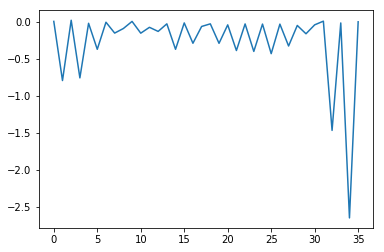

In [0]:
plt.plot(means)

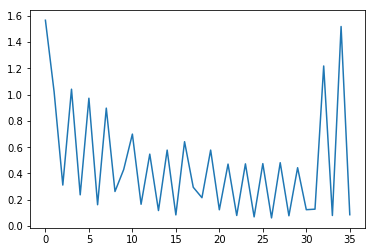

In [0]:
plt.plot(stds)

In [0]:
def find_modules(m, cond):
    if cond(m): return [m]
    return sum([find_modules(o,cond) for o in m.children()], [])

In [0]:
mods[0].num_layers

1

In [0]:

def append_stat(hook, mod, inp, outp):
    d = outp.data
    hook.mean,hook.std = d.mean().item(),d.std().item()

In [0]:
mdl = learn.model.to(torch.device('cuda'))


In [0]:
def get_batch(dl, run):
    run.xb,run.yb = next(iter(dl))
    for cb in run.cbs: cb.set_runner(run)
    run('begin_batch')
    return run.xb,run.yb

In [0]:
xb,yb = data_clas.one_batch()

In [0]:
data_clas.train_dl.x.to(torch.device('cuda'))

AttributeError: ignored

In [0]:
for hook in hooks: print(hook.mean,hook.std)

In [0]:
with Hooks(mods, append_stat) as hooks:
    mdl(xb)
    for hook in hooks: print(hook.mean,hook.std)

In [0]:
mdl

In [0]:
>>> rnn = nn.LSTM(10, 20, 2)
>>> input = torch.randn(5, 3, 10)
>>> h0 = torch.randn(2, 3, 20)
>>> c0 = torch.randn(2, 3, 20)

In [0]:
rnn.register_forward_hook(hook)


In [0]:
>>> output, (hn, cn) = rnn(input, (h0, c0))


> <ipython-input-114-90662714e63a>(4)hook()
-> return o.mean().item(),o.std().item()
(Pdb) o 
(tensor([[[-2.5948e-01, -8.9714e-02, -3.8792e-01, -1.2304e-01, -2.9241e-01,
          -4.2353e-01, -5.5217e-02,  2.7919e-01,  5.0661e-01,  7.4136e-02,
           3.4006e-02, -3.3203e-02, -7.0854e-02,  2.9344e-01,  1.4524e-01,
          -5.5786e-01,  8.9902e-02,  3.1441e-02,  6.4520e-02, -1.6160e-01],
         [-3.2259e-01,  9.8162e-02, -3.0071e-01,  1.1216e-01, -1.7026e-01,
           1.1765e-01,  1.2366e-01, -2.1583e-01, -5.0714e-01,  5.6318e-01,
           1.7843e-01,  1.4180e-01, -1.9182e-01, -6.0614e-04, -1.7267e-01,
          -5.3232e-01,  1.8171e-02,  3.6531e-01, -1.7608e-01, -5.5089e-01],
         [ 3.3725e-02,  3.2056e-01,  6.3262e-01, -1.3860e-02, -3.8328e-01,
          -2.0100e-01, -2.2671e-01,  2.6368e-01,  3.9997e-02,  1.7674e-01,
          -1.4727e-01,  5.0521e-02, -4.0556e-01,  4.1815e-02,  2.0404e-01,
          -1.7777e-01, -2.4711e-01,  9.4845e-02, -5.0206e-01, -1.8404e-01]],



BdbQuit: ignored

Testing Out Activation Stats With Vision. 



Experimenting with Entanglement and Soft Nearest Neighbor Loss